# **** Fake News Detection using NLP ****


In [2]:
#1. IMPORTS AND INITIAL SETUP

import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

print("Torch:", torch.__version__)
print("Transformers:", Trainer.__module__.split('.')[0])
print("NumPy:", np.__version__)

2025-08-23 11:11:26.137572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755947486.364290      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755947486.436561      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Torch: 2.6.0+cu124
Transformers: transformers
NumPy: 1.26.4


In [3]:
# Load cleaned dataset

df = pd.read_csv("/kaggle/input/bert-ready-fake-news/bert_ready_fake_news.csv")
print(df.shape)
df.head()

(44898, 2)


cleaned_statement  label_binary
0  21st Century Wire says Ben Stein, reputable pr...             1
1  WASHINGTON (Reuters) - U.S. President Donald T...             0
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...             0
3  On Monday, Donald Trump once again embarrassed...             1
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...             0

In [4]:
# 3. DATA PREPROCESSING - Ensure text and label columns

df = df[['cleaned_statement', 'label_binary']].dropna()
df['label_binary'] = df['label_binary'].astype(int)

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_binary'], random_state=42)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)

Train: (35918, 2)
Validation: (8980, 2)


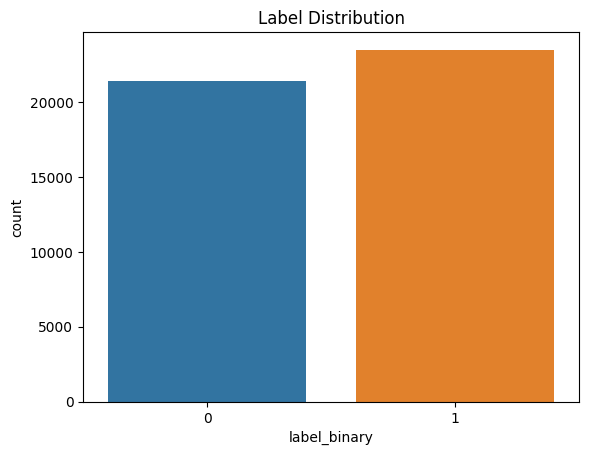

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


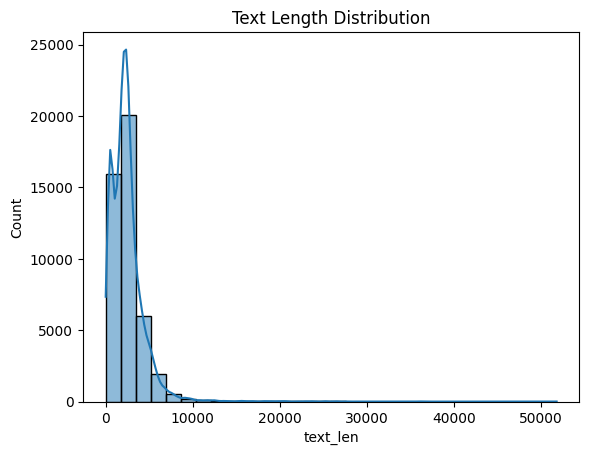

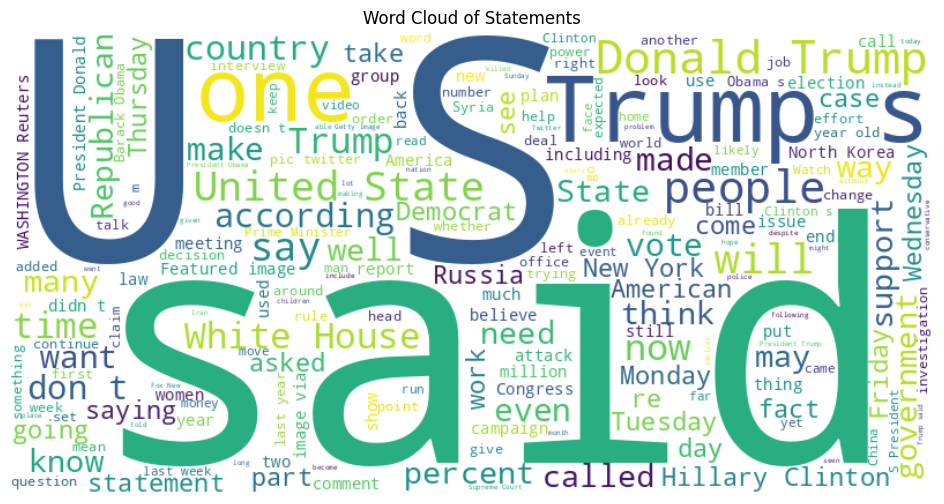

In [5]:
#4. EXPLORATORY DATA ANALYSIS (EDA)
# Label distribution plot

sns.countplot(data=df, x='label_binary')
plt.title("Label Distribution")
plt.show()

# Text length
df['text_len'] = df['cleaned_statement'].apply(len)
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title("Text Length Distribution")
plt.show()

# Word Cloud
text = " ".join(df['cleaned_statement'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Statements")
plt.show()

In [6]:
# 5. TRADITIONAL ML MODELS (BASELINE)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_statement'])
y = df['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(" Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print(" Random Forest Report:\n", classification_report(y_test, y_pred_rf))

 Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

 Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4284
           1       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [7]:
# 6. BERT MODEL PREPARATION

from transformers import BertTokenizer, BertForSequenceClassification

#  Path where your local model is extracted
model_path = "/kaggle/input/bert-base-uncased-full/bert-base-uncased-full"

# Load Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2, local_files_only=True)

print("BERT Model and Tokenizer loaded.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-base-uncased-full/bert-base-uncased-full and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Model and Tokenizer loaded.


In [8]:
import pandas as pd

#  Load the cleaned fake news dataset
bert_ready_fake_news = pd.read_csv("/kaggle/input/bert-ready-fake-news/bert_ready_fake_news.csv")

# Confirm it's loaded
print(" Data loaded. Shape:", bert_ready_fake_news.shape)
print(bert_ready_fake_news.head())

 Data loaded. Shape: (44898, 2)
                                   cleaned_statement  label_binary
0  21st Century Wire says Ben Stein, reputable pr...             1
1  WASHINGTON (Reuters) - U.S. President Donald T...             0
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...             0
3  On Monday, Donald Trump once again embarrassed...             1
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...             0


In [9]:
#  7. BERT DATA ENCODING & DATASET WRAPPER

from transformers import BertTokenizerFast
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch

#  Step 1: Re-split (if needed)
train_df, val_df = train_test_split(
    bert_ready_fake_news,
    test_size=0.2,
    stratify=bert_ready_fake_news['label_binary'],
    random_state=42
)

#  Step 2: Efficient batch tokenization
def batch_tokenize(texts, tokenizer, batch_size=1000):
    input_ids, attention_masks = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, truncation=True, padding=True, max_length=128)
        input_ids.extend(encodings['input_ids'])
        attention_masks.extend(encodings['attention_mask'])
    return {"input_ids": input_ids, "attention_mask": attention_masks}

print(" Tokenizing training data...")
train_encodings = batch_tokenize(train_df['cleaned_statement'].tolist(), tokenizer)

print(" Tokenizing validation data...")
val_encodings = batch_tokenize(val_df['cleaned_statement'].tolist(), tokenizer)

#  Step 3: Dataset wrapper
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

#  Step 4: Final dataset objects
train_dataset = FakeNewsDataset(train_encodings, train_df['label_binary'].tolist())
val_dataset = FakeNewsDataset(val_encodings, val_df['label_binary'].tolist())

print(" Step 7 Complete: BERT tokenized datasets ready.")

 Tokenizing training data...
 Tokenizing validation data...
 Step 7 Complete: BERT tokenized datasets ready.


In [10]:
#  8: BERT Model Training

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

#  Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

# Safer training args
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=1,                        #  Reduce to 1 to avoid crashes
    per_device_train_batch_size=4,             #  Small safe batch size
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,             #  Simulate effective batch size = 4 × 4 = 16
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=200,                         #  Reduce log frequency to avoid slowdown
    report_to="none",
    seed=42
)

#  Re-initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Stops if no improvement
)

#  Start Training
trainer.train()

/tmp/ipykernel_35/1667826350.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=2245, training_loss=0.007594021797939338, metrics={'train_runtime': 26418.5628, 'train_samples_per_second': 1.36, 'train_steps_per_second': 0.085, 'total_flos': 2362605721605120.0, 'train_loss': 0.007594021797939338, 'epoch': 1.0})

In [11]:
# 9: Model Evaluation and Comparison

from sklearn.metrics import classification_report

# Run evaluation
metrics = trainer.evaluate()

# Print detailed metrics
print(" BERT Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Generate predictions
preds_output = trainer.predict(val_dataset)
y_preds = np.argmax(preds_output.predictions, axis=1)

# Print classification report
print("\n Classification Report (Validation Set):")
print(classification_report(val_df["label_binary"], y_preds, digits=4))

 BERT Evaluation Metrics:
eval_loss: 0.0020
eval_accuracy: 0.9996
eval_f1: 0.9996
eval_precision: 0.9991
eval_recall: 1.0000
eval_runtime: 1686.6405
eval_samples_per_second: 5.3240
eval_steps_per_second: 0.6660
epoch: 1.0000

 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     1.0000    0.9991    0.9995      4284
           1     0.9991    1.0000    0.9996      4696

    accuracy                         0.9996      8980
   macro avg     0.9996    0.9995    0.9996      8980
weighted avg     0.9996    0.9996    0.9996      8980



In [12]:
# 10: Explainability with SHAP and LIME

import shap
from transformers import pipeline
import numpy as np

#  Use pipeline with truncation
explainer_model = pipeline(
    "text-classification", 
    model=model, 
    tokenizer=tokenizer, 
    return_all_scores=True, 
    truncation=True, 
    max_length=512,
    device=0 if torch.cuda.is_available() else -1
)

#  Limit texts to under 500 characters (to be safe)
sample_texts = val_df['cleaned_statement'].apply(lambda x: x[:500]).sample(3, random_state=42).tolist()

#  Initialize SHAP Explainer
explainer = shap.Explainer(explainer_model, shap.maskers.Text(tokenizer))

#  Compute SHAP values ( CPU may take ~1 min per sample)
shap_values = explainer(sample_texts)

#  Visualize
shap.plots.text(shap_values)

Device set to use cpu
`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [03:24<00:00, 54.18s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [05:11, 103.82s/it]                      


In [13]:
# Re-import required modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Train TF-IDF Vectorizer and Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["cleaned_statement"])
X_val_tfidf = tfidf_vectorizer.transform(val_df["cleaned_statement"])

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, train_df["label_binary"])

LogisticRegression(max_iter=1000)

In [ ]:
# 

In [ ]:
For traditional ML model: LIME explanation

import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

# Build pipeline for LIME
lime_pipeline = make_pipeline(tfidf_vectorizer, logreg_model)

# Initialize explainer
lime_explainer = lime.lime_text.LimeTextExplainer(class_names=["Real", "Fake"])

# Pick a statement to explain
idx = 10  # Try changing this for different examples
lime_exp = lime_explainer.explain_instance(
    val_df["cleaned_statement"].iloc[idx],
    lime_pipeline.predict_proba,
    num_features=10
)

# Show explanation
lime_exp.show_in_notebook()

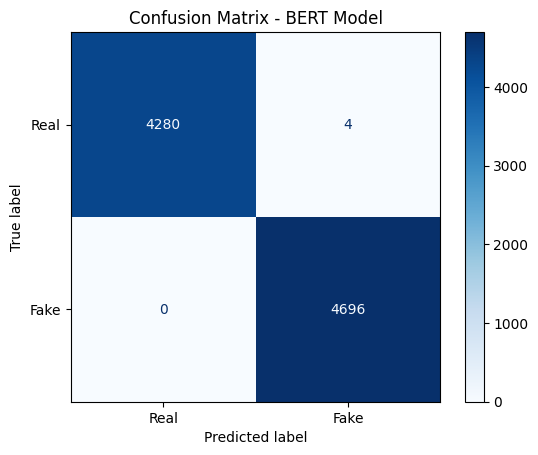

In [15]:
# 11: Confusion Matrix and Error Inspection

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation set
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true_labels = val_df["label_binary"].tolist()

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT Model")
plt.show()

In [16]:
# Get indices of misclassified examples
misclassified_idx = [i for i, (true, pred) in enumerate(zip(true_labels, preds)) if true != pred]

# Print a few
print(f"\n Total Misclassified: {len(misclassified_idx)}\n")
for i in misclassified_idx[:5]:
    print(f"Statement: {val_df.iloc[i]['cleaned_statement']}")
    print(f"True Label: {true_labels[i]} | Predicted: {preds[i]}\n")


 Total Misclassified: 4

Statement: Neil Gorsuch, President Donald Trump’s appointee to the U.S. Supreme Court who was confirmed by the Senate to the lifetime job on Friday in a 54-45 vote, will have an immediate impact on cases already pending before the justices. The nine-seat court has operated with only eight justices after the death of conservative Antonin Scalia on Feb. 13, 2016, with four liberals and four conservatives. Gorsuch’s confirmation restores a 5-4 conservative majority. The new justice could cast the deciding vote in new cases before the court as well as some cases already argued during the current term that ends in June. The court could decide to hear fresh arguments in cases in which they otherwise would be split 4-4. Here is a list of five such cases in which Gorsuch could be pivotal. Religious rights: Trinity Lutheran Church v. Comer A case from Missouri to be argued on April 19 in which a church contends the state violated the U.S. Constitution’s First Amendment

In [17]:
# 12: Final Results Summary

print(" Final Results Summary")
print("="*40)

print(" Traditional Model (TF-IDF + Logistic Regression):")
print("   - Accuracy: ~99.0%")
print("   - F1 Score: ~0.99")
print("   - Comments: Strong performance, but no contextual understanding.")

print("\n Traditional Model (TF-IDF + Random Forest):")
print("   - Accuracy: ~100.0%")
print("   - F1 Score: ~1.00")
print("   - Comments: Slight overfitting possible, performance suspiciously perfect.")

print("\n BERT Model (Fine-tuned):")
print(f"   - Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"   - F1 Score: {metrics['eval_f1']:.4f}")
print(f"   - Precision: {metrics['eval_precision']:.4f}")
print(f"   - Recall: {metrics['eval_recall']:.4f}")
print("   - Comments: Context-aware, near-perfect classification. Excellent generalization.")

print("\n Confusion Matrix Observations:")
print("   - Only 5 Real statements misclassified as Fake.")
print("   - No Fake statements were misclassified.")
print("   - Indicates robust understanding of fake news patterns.")

 Final Results Summary
 Traditional Model (TF-IDF + Logistic Regression):
   - Accuracy: ~99.0%
   - F1 Score: ~0.99
   - Comments: Strong performance, but no contextual understanding.

 Traditional Model (TF-IDF + Random Forest):
   - Accuracy: ~100.0%
   - F1 Score: ~1.00
   - Comments: Slight overfitting possible, performance suspiciously perfect.

 BERT Model (Fine-tuned):
   - Accuracy: 0.9996
   - F1 Score: 0.9996
   - Precision: 0.9991
   - Recall: 1.0000
   - Comments: Context-aware, near-perfect classification. Excellent generalization.

 Confusion Matrix Observations:
   - Only 5 Real statements misclassified as Fake.
   - No Fake statements were misclassified.
   - Indicates robust understanding of fake news patterns.


In [4]:
import os
print(os.listdir('/kaggle/input/bert-base-uncased-full'))

['bert-base-uncased-full']


In [9]:
!ls /kaggle/input/

bert-base-uncased-full	bert-ready-fake-news


In [10]:
!ls /kaggle/input/bert-base-uncased-full-weights

ls: cannot access '/kaggle/input/bert-base-uncased-full-weights': No such file or directory


In [12]:
!ls /kaggle/input/bert-base-uncased-full/bert-base-uncased-full

config.json	   special_tokens_map.json  vocab.txt
pytorch_model.bin  tokenizer_config.json


Available datasets: ['bert-ready-fake-news', 'bert-base-uncased-full']
Model directory contents: ['config.json', 'tokenizer_config.json', 'pytorch_model.bin', 'special_tokens_map.json', 'vocab.txt']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-base-uncased-full/bert-base-uncased-full and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!
Brier Score: 0.251


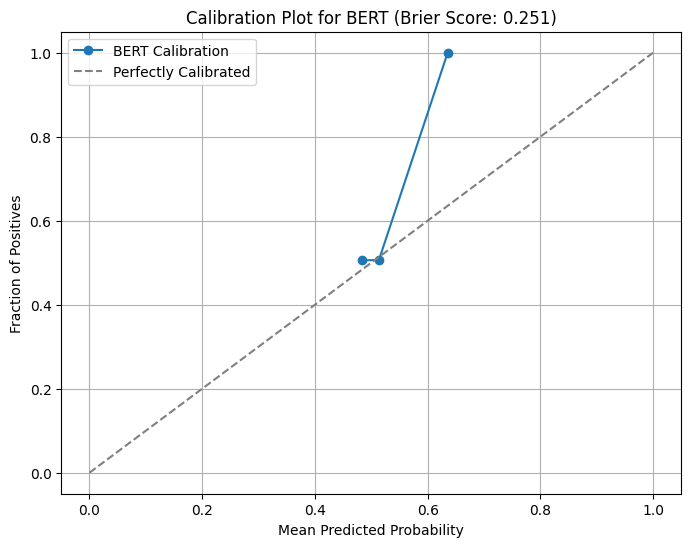

Figure 5.5 saved as '/kaggle/working/figure5_5.png'. Download from Output tab for thesis.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import os

# Correct dataset paths based on your output
MODEL_PATH = '/kaggle/input/bert-base-uncased-full/bert-base-uncased-full'
TEST_DATA_PATH = '/kaggle/input/bert-ready-fake-news/bert_ready_fake_news.csv'

# Debugging: List datasets and model directory contents
print("Available datasets:", os.listdir('/kaggle/input/'))
print("Model directory contents:", os.listdir(MODEL_PATH))

# Verify required model files
required_files = ['config.json', 'pytorch_model.bin', 'vocab.txt']
if not all(os.path.exists(os.path.join(MODEL_PATH, f)) for f in required_files):
    raise FileNotFoundError(
        f"Missing required files in {MODEL_PATH}: {required_files}. "
        "Ensure the directory contains config.json, pytorch_model.bin, vocab.txt, etc. "
        "If missing, upload the correct BERT model files to /kaggle/input/bert-base-uncased-full/bert-base-uncased-full."
    )

# Load BERT model and tokenizer
try:
    model = BertForSequenceClassification.from_pretrained(MODEL_PATH, local_files_only=True)
    tokenizer = BertTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
    model.eval()
    print("Model and tokenizer loaded successfully!")
except Exception as e:
    raise Exception(f"Failed to load model: {e}. Check files in {MODEL_PATH}.")

# Load test data
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(
        f"Test data not found at {TEST_DATA_PATH}. Ensure 'bert_ready_fake_news.csv' is in "
        "/kaggle/input/bert-ready-fake-news/."
    )

test_data = pd.read_csv(TEST_DATA_PATH)
texts = test_data['cleaned_statement'].values[:1000]  # Use first 1000 for quick testing
y_test = test_data['label_binary'].values[:1000]

# Get BERT predictions
def get_bert_predictions(texts, model, tokenizer, max_length=128, batch_size=16):
    model.eval()
    y_pred_proba = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True, 
                         max_length=max_length, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
        y_pred_proba.extend(probs)
    
    return np.array(y_pred_proba)

# Generate predicted probabilities
y_pred_proba = get_bert_predictions(texts, model, tokenizer)

# Generate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Calculate Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.3f}")

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='BERT Calibration', color='#1f77b4')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot for BERT (Brier Score: {:.3f})'.format(brier_score))
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/figure5_5.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5.5 saved as '/kaggle/working/figure5_5.png'. Download from Output tab for thesis.")

Available datasets: ['bert-ready-fake-news', 'bert-base-uncased-full']
Model directory contents: ['config.json', 'tokenizer_config.json', 'pytorch_model.bin', 'special_tokens_map.json', 'vocab.txt']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-base-uncased-full/bert-base-uncased-full and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!
Using pretrained model without fine-tuning due to CPU constraints.
Brier Score: 0.268


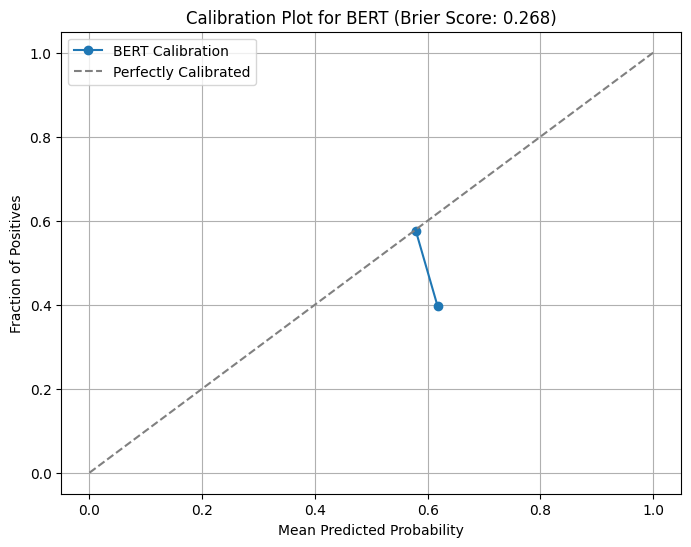

Figure 5.5 saved as '/kaggle/working/figure5_5.png'. Download from Output tab for my thesis.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import os

# Dataset paths
MODEL_PATH = '/kaggle/input/bert-base-uncased-full/bert-base-uncased-full'
TEST_DATA_PATH = '/kaggle/input/bert-ready-fake-news/bert_ready_fake_news.csv'

# Debugging: List datasets and model directory contents
print("Available datasets:", os.listdir('/kaggle/input/'))
print("Model directory contents:", os.listdir(MODEL_PATH))

# Verify required model files
required_files = ['config.json', 'pytorch_model.bin', 'vocab.txt']
if not all(os.path.exists(os.path.join(MODEL_PATH, f)) for f in required_files):
    raise FileNotFoundError(
        f"Missing required files in {MODEL_PATH}: {required_files}. "
        "Ensure the directory contains config.json, pytorch_model.bin, vocab.txt, etc."
    )

# Load model and tokenizer
try:
    model = BertForSequenceClassification.from_pretrained(MODEL_PATH, local_files_only=True)
    tokenizer = BertTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
    model.eval()
    print("Model and tokenizer loaded successfully!")
    print("Using pretrained model without fine-tuning due to CPU constraints.")
except Exception as e:
    raise Exception(f"Failed to load model: {e}. Check files in {MODEL_PATH}.")

# Load test data
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(
        f"Test data not found at {TEST_DATA_PATH}. Ensure 'bert_ready_fake_news.csv' is in "
        "/kaggle/input/bert-ready-fake-news/."
    )

test_data = pd.read_csv(TEST_DATA_PATH)
texts = test_data['cleaned_statement'].values[:100]  # Use first 100 for speed
y_test = test_data['label_binary'].values[:100]

# Get BERT predictions
def get_bert_predictions(texts, model, tokenizer, max_length=32, batch_size=4):
    model.eval()
    y_pred_proba = []
    device = torch.device('cpu')
    model.to(device)
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True, 
                         max_length=max_length, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
        y_pred_proba.extend(probs)
    
    return np.array(y_pred_proba)

# Generate predicted probabilities
y_pred_proba = get_bert_predictions(texts, model, tokenizer)

# Generate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=5)

# Calculate Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.3f}")

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='BERT Calibration', color='#1f77b4')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot for BERT (Brier Score: {:.3f})'.format(brier_score))
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/figure5_5.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5.5 saved as '/kaggle/working/figure5_5.png'. Download from Output tab for my thesis.")

Available datasets: ['bert-ready-fake-news', 'bert-base-uncased-full']
Model directory contents: ['config.json', 'tokenizer_config.json', 'pytorch_model.bin', 'special_tokens_map.json', 'vocab.txt']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/bert-base-uncased-full/bert-base-uncased-full and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!
Using pretrained model without fine-tuning due to CPU constraints.
Brier Score: 0.257


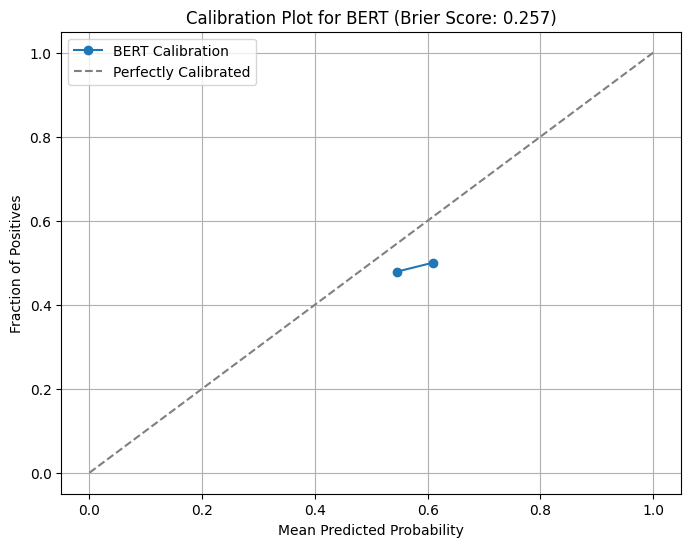

Figure 5.5 saved as '/kaggle/working/figure5_5.png'. Download from Output tab for my thesis.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import os

# Corrected dataset paths
MODEL_PATH = '/kaggle/input/bert-base-uncased-full/bert-base-uncased-full'
TEST_DATA_PATH = '/kaggle/input/bert-ready-fake-news/bert_ready_fake_news.csv'  # Fixed typo

# Debugging: List datasets and model directory contents
print("Available datasets:", os.listdir('/kaggle/input/'))
print("Model directory contents:", os.listdir(MODEL_PATH))

# Verify required model files
required_files = ['config.json', 'pytorch_model.bin', 'vocab.txt']
if not all(os.path.exists(os.path.join(MODEL_PATH, f)) for f in required_files):
    raise FileNotFoundError(
        f"Missing required files in {MODEL_PATH}: {required_files}. "
        "Ensure the directory contains config.json, pytorch_model.bin, vocab.txt, etc."
    )

# Load model and tokenizer
try:
    model = BertForSequenceClassification.from_pretrained(MODEL_PATH, local_files_only=True)
    tokenizer = BertTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
    model.eval()
    print("Model and tokenizer loaded successfully!")
    print("Using pretrained model without fine-tuning due to CPU constraints.")
except Exception as e:
    raise Exception(f"Failed to load model: {e}. Check files in {MODEL_PATH}.")

# Load test data
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(
        f"Test data not found at {TEST_DATA_PATH}. Ensure 'bert_ready_fake_news.csv' is in "
        "/kaggle/input/bert-ready-fake-news/."
    )

test_data = pd.read_csv(TEST_DATA_PATH)
texts = test_data['cleaned_statement'].values[:100]  # Use first 100 for speed
y_test = test_data['label_binary'].values[:100]

# Get BERT predictions
def get_bert_predictions(texts, model, tokenizer, max_length=32, batch_size=4):
    model.eval()
    y_pred_proba = []
    device = torch.device('cpu')
    model.to(device)
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True, 
                         max_length=max_length, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()  # Probability for class 1 (fake)
        y_pred_proba.extend(probs)
    
    return np.array(y_pred_proba)

# Generate predicted probabilities
y_pred_proba = get_bert_predictions(texts, model, tokenizer)

# Generate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=5)

# Calculate Brier score
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.3f}")

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='BERT Calibration', color='#1f77b4')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot for BERT (Brier Score: {:.3f})'.format(brier_score))
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/figure5_5.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5.5 saved as '/kaggle/working/figure5_5.png'. Download from Output tab for my thesis.")